## Classification: Customer Churn

This project aims to build a machine learning classification model to predict customer churn. The dataset comes from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) and contains information about a fictional telco company. Each row represents a customer and each column contains customer attributes, which are a mix of numeric and categorical forms. Customers who left within the last month are labeled as churn.

Objectives:
1. Build a classifer model to predict customer churn and compare different estimators (Logistic Regression, Random Forest, Naive Bayes). 
2. Implement Cross Validation to minimize risk of overfitting.
3. Implement methods to deal with class imbalance.

In [63]:
from pathlib import Path
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import importlib
import common


In [64]:
df = pd.read_csv(Path('WA_Fn-UseC_-Telco-Customer-Churn.csv'))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [65]:
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [66]:
# Convert datatypes
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop NaNs
df = df.dropna()


We'll begin with a few features, get the workflow and model working, then add more features to see if the model performance improves. This model will also serve as the baseline.

In [67]:
features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

X = df[features]


In [68]:
# Get labels column
y = LabelEncoder().fit_transform(df['Churn'])

# Test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print("Complete dataset:", X.shape)
print("Train dataset:", X_train.shape)
print("Test dataset:", X_test.shape)


Complete dataset: (7032, 8)
Train dataset: (5625, 8)
Test dataset: (1407, 8)


In [69]:
# Class balance check
y.mean()


0.26578498293515357

In this dataset only about 27% of customers churn which means the dataset is unbalanced. We'll deal with this later. For now let's get the initial model built.

In [70]:
# Last datatype check
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 6030 to 862
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tenure           5625 non-null   int64  
 1   PhoneService     5625 non-null   object 
 2   MultipleLines    5625 non-null   object 
 3   InternetService  5625 non-null   object 
 4   Contract         5625 non-null   object 
 5   PaymentMethod    5625 non-null   object 
 6   MonthlyCharges   5625 non-null   float64
 7   TotalCharges     5625 non-null   float64
dtypes: float64(2), int64(1), object(5)
memory usage: 395.5+ KB


In [71]:
# Build model pipeline
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_features = [f for f in features if f not in num_features]

ohe = ColumnTransformer([
    ('ohe_features', OneHotEncoder(), cat_features),
    ('scaled_num', StandardScaler(), num_features)
])

lr_pipe = Pipeline([('ohe', ohe),
                    ('lr', LogisticRegression())])

lr_pipe.fit(X_train, y_train)


Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('ohe_features',
                                                  OneHotEncoder(),
                                                  ['PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaymentMethod']),
                                                 ('scaled_num',
                                                  StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('lr', LogisticRegression())])

In [72]:
def model_evaluation(model, X, y):
    """Compute and display model's score metrics"""
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y, y_pred), 4)
    scores['recall'] = round(metrics.recall_score(y, y_pred), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y, probs)
    scores['area under precision-recall curve'] = round(
        metrics.auc(recalls, precisions), 4)

    # Print scores
    for metric, score in scores.items():
        print(f'Test {metric}: {score}')

    return scores


In [73]:
# Baseline model
model_evaluation(lr_pipe, X_test, y_test)
print(f"Model weights:\n{lr_pipe.named_steps['lr'].coef_}")
# Metrics for each class
print(classification_report(y_test, lr_pipe.predict(X_test)))


Test accuracy: 0.7861
Test precision: 0.6174
Test recall: 0.5134
Test area under precision-recall curve: 0.6424
Model weights:
[[ 0.20818339 -0.20850892 -0.23954177  0.20818339  0.03103285 -0.18456465
   0.7733577  -0.58911859  0.84270159 -0.05488144 -0.78814568 -0.02675818
  -0.16698435  0.34349142 -0.15007443 -1.47039759  0.13048608  0.68277358]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [74]:
# Confusion matrix
pd.DataFrame(confusion_matrix(y_test, lr_pipe.predict(X_test)),
             index=['class 0 actual', 'class 1 actual'],
             columns=['class 0 pred', 'class 1 pred'])


,class 0 pred,class 1 pred
class 0 actual,914,119
class 1 actual,182,192


Now that the model is working, let's wrap everything into functions to facilitate model iterations and maintenance. We want to be able to start from the raw csv (so that hypothetically newly recorded data in the future can be used), process it, extract features of interest, and run the classifier model in an automated workflow to minimize errors.

In [75]:
# Reload necessary for notebooks if import was updated
importlib.reload(common)
path = Path('WA_Fn-UseC_-Telco-Customer-Churn.csv')
features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
common.run_model(path, features, LogisticRegression())


              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('ohe_features',
                                                  OneHotEncoder(),
                                                  ['PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaymentMethod']),
                                                 ('scaled_num',
                                                  StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('est', LogisticRegression())])

In [76]:
# All features included
importlib.reload(common)
path = Path('WA_Fn-UseC_-Telco-Customer-Churn.csv')
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
common.run_model(path, features, LogisticRegression())


              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('ohe_features',
                                                  OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('scaled_num',
                                                  StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('est', LogisticRegression())])

Including all features does not appear to improve model performance. Next let's try a Random Forest Classifier.

In [77]:
# Reload necessary for notebooks if import was updated
importlib.reload(common)
path = Path('WA_Fn-UseC_-Telco-Customer-Churn.csv')
features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
common.run_model(path, features,
                 RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42))


              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1033
           1       0.59      0.49      0.53       374

    accuracy                           0.77      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.77      0.76      1407



Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('ohe_features',
                                                  OneHotEncoder(),
                                                  ['PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaymentMethod']),
                                                 ('scaled_num',
                                                  StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('est', RandomForestClassifier(max_depth=10, random_state=42))])

The more powerful Random Forest classifier appears to be overfitting. Let's add some Cross Validation to minimize that.

In [84]:
importlib.reload(common)
path = Path('WA_Fn-UseC_-Telco-Customer-Churn.csv')
features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

param_grid = {'est__max_depth': range(4, 9),
              'est__min_samples_split': [4, 5, 6],
              'est__min_samples_leaf': [1, 2, 3]}

model = common.run_model(path, features,
                         RandomForestClassifier(n_estimators=100, random_state=42), param_grid)


Fitting 3 folds for each of 45 candidates, totalling 135 fits
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407



In [85]:
print(f'Best parameters from CV: {model.best_params_}')


Best parameters from CV: {'est__max_depth': 6, 'est__min_samples_leaf': 1, 'est__min_samples_split': 6}


Cross Validation for the Random Forest classifier does not seem to have significantly improved the model performance. The last lever to try is different feature subsets or additional feature engineering. We'll skip that exercise for now and instead look at one more estimator then class imbalances.

Let's also compare RidgeClassifierCV:

In [79]:
# Build model pipeline
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

cat_features = [f for f in features if f not in num_features]

ohe = ColumnTransformer([
    ('ohe_features', OneHotEncoder(), cat_features),
    ('scaled_num', StandardScaler(), num_features)
])

pipe = Pipeline([('ohe', ohe),
                 ('lr', RidgeClassifierCV(alphas=(0.01, 0.1, 1.0, 10.0, 100)))])

pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test)))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



RidgeClassifierCV does not appear to improve the prediction power over Logistic Regression. Accuracy remains the same for both with minor differences for precision and recall.

Let's also try a Naive Bayes model. While its not expected to have better performance, a benefit of the developed functional approach to the classifier model is that trying alternative estimators is quick and easy.

In [80]:
importlib.reload(common)
path = Path('WA_Fn-UseC_-Telco-Customer-Churn.csv')
features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
common.run_model(path, features, GaussianNB())


              precision    recall  f1-score   support

           0       0.90      0.68      0.77      1033
           1       0.47      0.78      0.59       374

    accuracy                           0.71      1407
   macro avg       0.68      0.73      0.68      1407
weighted avg       0.78      0.71      0.72      1407



Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('ohe_features',
                                                  OneHotEncoder(),
                                                  ['PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'Contract',
                                                   'PaymentMethod']),
                                                 ('scaled_num',
                                                  StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('est', GaussianNB())])

### Support Vector Machines
Let's experiment with SVMs. We'll also organize all the different models into one array for better maintenance.

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.63      0.47      0.53       374

    accuracy                           0.78      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407

              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1033
           1       0.66      0.45      0.53       374

    accuracy                           0.79      1407
   macro avg       0.74      0.68      0.70      1407
weighted avg       0.78      0.79      0.78      1407

              preci

<Axes: title={'center': 'Accuracy of various models'}, xlabel='Model'>

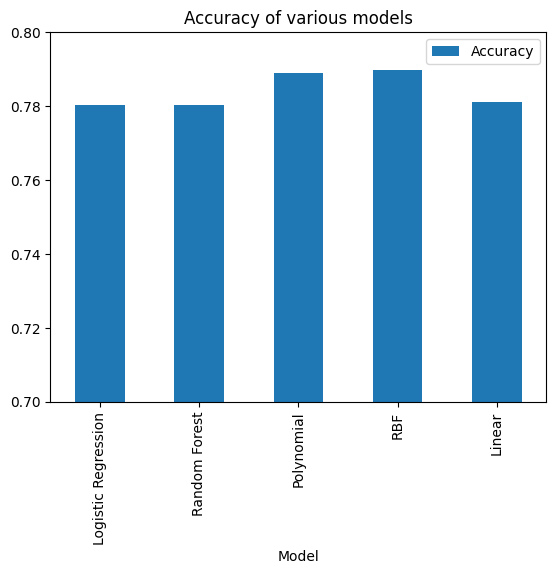

In [81]:
importlib.reload(common)
path = Path('WA_Fn-UseC_-Telco-Customer-Churn.csv')
features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

# test-train split
df = common.preprocess(path)
X = df[features]
y = LabelEncoder().fit_transform(df['Churn'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# hyperparameters
C = 1.0

models = [
    ("Logistic Regression", common.run_model(
        path, features, LogisticRegression())),
    ("Random Forest", common.run_model(path, features,
                                       RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42))),
    ("Polynomial", common.run_model(path, features,
                                    svm.SVC(kernel='poly', degree=2, C=C, gamma='auto'))),
    ("RBF", common.run_model(path, features,
                             svm.SVC(kernel='rbf', C=C, gamma='auto'))),
    ("Linear", common.run_model(path, features,
                                svm.SVC(kernel='linear', C=1, gamma='auto')))
]

pd.DataFrame([
    (name, cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=3)
     .mean()) for name, clf in models
], columns=["Model", "Accuracy"]).plot(x="Model",
                                       y="Accuracy",
                                       kind="bar",
                                       title="Accuracy of various models",
                                       ylim=[0.7, 0.8])


The SVM models appear to offer slightly better accuracy without any tuning. Certainly warrants a deeper look for model improvement.

### Unbalanced Classes

When there are unbalanced classes, metrics like **accuracy** can be misleading since a high accuracy could be obtained by simply always predicting the majority class. In this case, **precision** and **recall** may be better metrics for evaluating classifier performance. A high precision means low **false positives** and high recall means low **false negatives**.

To account for the unbalanced classes, let's first try simple under-sampling and over-sampling methods before something more complicated like SMOTE.

**Aside:** With any class rebalancing method, it is important to only perform balancing on the *training* set. The test should be split off before any balancing is performed.

In [82]:
# Under-sampling
importlib.reload(common)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
US = RandomUnderSampler(random_state=42)
X_us, y_us = US.fit_resample(X_train, y_train)
print(f'Shape of train data: {X_us.shape}')

features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

model = common.fit_model(features, X_us, y_us, LogisticRegression())

# Evaluate
# common.model_evaluation(model, X_test, y_test, 'test')
# common.model_evaluation(model, X_us, y_us, 'train')
print(classification_report(y_test, model.predict(X_test)))


Shape of train data: (2990, 8)
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.81      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407



Overall accuracy decreased to 0.73 from 0.79 of the baseline model. However, rebalancing the classes has significantly increased recall for class 1 (churners, which originally was only 27% of the dataset) from 0.51 to 0.81.

In [83]:
# Over-sampling
importlib.reload(common)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
OS = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_os, y_os = OS.fit_resample(X_train, y_train)
print(f'Shape of train data: {X_os.shape}')

features = ['tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
            'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

model = common.fit_model(features, X_os, y_os, LogisticRegression())

# Evaluate
print(classification_report(y_test, model.predict(X_test)))


Shape of train data: (8260, 8)
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407



Over-sampling results in very similar scores to under-sampling in this case.